## Finding and Hedging Portfolio Beta Using Linear Regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import Markdown, display
from openbb import obb
from statsmodels import regression

In [2]:
obb.user.preferences.output_type = "dataframe"

Define the stock symbols including the benchmark "SPY"

In [3]:
symbols = [
    "NEM",
    "RGLD",
    "SSRM",
    "CDE",
    "LLY",
    "UNH",
    "JNJ",
    "MRK",
    "SPY",
]

Fetch historical price data for the defined symbols from 2020-01-01 to 2022-12-31 using the "yfinance" provider

In [4]:
data = obb.equity.price.historical(
    symbols,
    start_date="2020-01-01",
    end_date="2025-12-31",
    provider="yfinance",
).pivot(columns="symbol", values="close")

Calculate the daily percentage returns for the benchmark "SPY" and drop any missing values

In [5]:
benchmark_returns = data.pop("SPY").pct_change().dropna()

Calculate the daily percentage returns for the portfolio and drop any missing values

In [6]:
portfolio_returns = data.pct_change().dropna().sum(axis=1)
portfolio_returns.name = "portfolio"

Plot the portfolio and benchmark daily returns

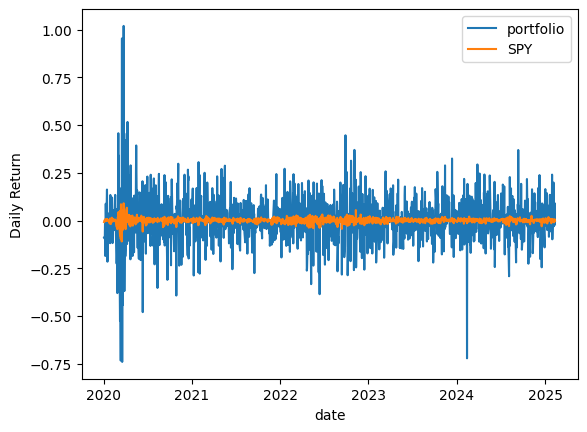

In [7]:
portfolio_returns.plot()
benchmark_returns.plot()
plt.ylabel("Daily Return")
plt.legend()
plt.show()

Define a function for linear regression to calculate alpha and beta

In [8]:
def linreg(x, y):
    # Add a column of 1s to fit alpha

    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    # Remove the constant now that we're done

    x = x[:, 1]
    return model.params[0], model.params[1]

Perform linear regression on the portfolio and benchmark returns to calculate alpha and beta

In [9]:
X = benchmark_returns.values
Y = portfolio_returns.values

In [10]:
alpha, beta = linreg(X, Y)

In [11]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.0013102379409258064'

'Beta: 5.435757755121334'

Plot the regression line

In [12]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

Plot the raw data

Text(0, 0.5, 'Portfolio daily return')

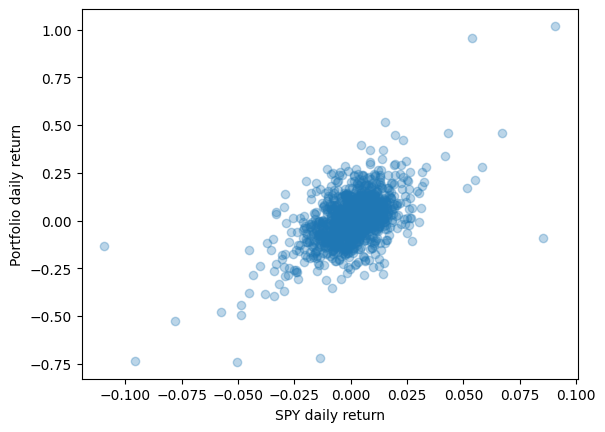

In [13]:
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")

Add the regression line

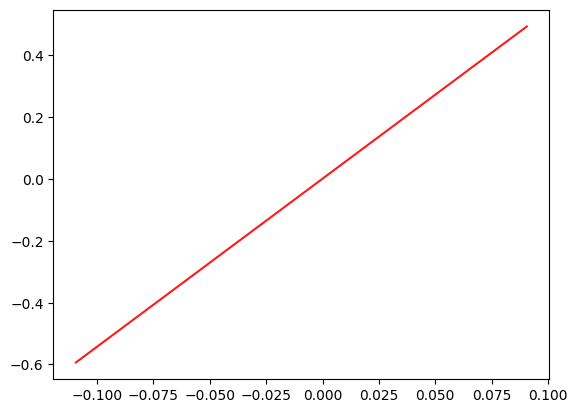

In [14]:
plt.plot(X2, Y_hat, "r", alpha=0.9)
plt.show()

Construct a portfolio with beta hedging

In [15]:
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns

Perform linear regression on the hedged portfolio returns and benchmark returns to calculate alpha and beta

In [16]:
P = hedged_portfolio_returns.values
alpha, beta = linreg(X, P)

In [17]:
display(f"Alpha: {alpha}")
display(f"Beta: {beta}")

'Alpha: 0.0013102379409258094'

'Beta: 3.3306690738754696e-15'

Define a function to calculate the information ratio

In [18]:
def information_ratio(portfolio_returns, benchmark_returns):
    """
    Determines the information ratio of a strategy.

    Parameters
    ----------
    portfolio_returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    benchmark_returns : int, float
        Daily returns of the benchmark or factor, noncumulative.
    Returns
    -------
    information_ratio : float
 
    """

    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    return active_return.mean() / tracking_error

Calculate the information ratio for the hedged and unhedged portfolios

In [19]:
hedged_ir = information_ratio(hedged_portfolio_returns, benchmark_returns)

In [20]:
unhedged_ir = information_ratio(portfolio_returns, benchmark_returns)

In [21]:
display(f"Hedged information ratio: {hedged_ir}")
display(f"Unhedged information ratio: {unhedged_ir}")

'Hedged information ratio: 0.0068053223321240044'

'Unhedged information ratio: 0.03131851559911904'